# Hypothesis tests Part 2 Intro

In this Notebook I will continue the **Hypothesis tests** main tests to clarify the difficulties while trying to understand this statistical concept. This is the second part of my series *"The Hypothesis Testing Bible"*. If you want to know further about the dataset or more elemental concepts, please check the first part on my GitHub repository. Link below.

https://github.com/Seniorveiga/Python_Projects/tree/main/Hypothesis%20Testing%20Bible

In this notebook we will have a walk over more complex tests. They will be:

## Index

- Proportion tests
    - Tests for single and two proportions
    - Proportions $\mathit{z}$-test
    - ${Chi^{2}}$ tests

- Non-parametric tests
    - Wilcoxon tests
    - Wilcoxon-Man-Whotney tests
    - Kruskal-Wallis tests

**Last update**: I have just finished the Proportion test part and my computer is not working at all due to lack of RAM. In case other person confronts the same problem, I´m going to divide it in a third notebook only for non-paramtric test.

## Packages reminder

To learn more about hypothesis tests, we will be working with two datasets, one that is called *late_shipments* and the other one called *republican_votes*. Right now we will be using only the first one in order to understand more about hypothesis tests.

The *late_shipments* dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. 
- The **"late"** columns denotes whether or not the part was delivered late. A value of "Yes" means that the part was delivered late, and a value of "No" means the part was delivered on time.

Also, for temporal comparing datasets we will use *repub_votes_potus_08_12* that has comparisons of the votes between republicans and democrats betweenn those years.

- Since the counties are the same in both years, these samples are paired (Used in the paired t-test chapter). The columns containing the samples are *"dem_percent_12"* and *"dem_percent_16"*.

## Packages and dataset import

Again, we import the package so that it appears again to do our operations and the hypothesis tests.

In [33]:
import pandas as pd
import pyarrow.feather as feather
import numpy as np 
from scipy.stats import norm, t, chi2, chisquare
import matplotlib.pyplot as plt
import pingouin
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [3]:
late_shipments = feather.read_feather("late_shipments.feather")
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


# Proportions tests

## Test for single proportions
### Reminder of z-Score use

Imagine now that we want to calculate the proportion of a certain population, we already did this in the first part of our Hypothesis testing Bible! The steps we took were the following:

1. We use the bootstrap distribution to calculate them the standard deviation with NumPy Package.
2. We calculate the standardized test statistic, the $\mathit{z}$-Score.
3. With the $\mathit{z}$-Score, we calculated the $\mathit{p}$-Value.
4. We decide the hypothesis that has more sense.

As the bootstrap distribution can be computationally exhausting for the computer, there are other options to do it which can be less tiring for the PC.

What we used for it was: 
$$\mathit{z}-Score = \frac{\widehat{p} - \mathit{p}}{SE(\widehat{p})}$$

If we assume that $H_{0}$ is true, then $\mathit{p}$ = $\mathit{p_{0}}$ so:
$$\mathit{z}-Score = \frac{\widehat{p} - \mathit{p_{0}}}{SE(\widehat{p})}$$

So knowing the value of $\mathit{SE}$, that we can look from the previous notebook, we would only need sample information that are $\widehat{p}$ and $\mathit{n}$, and the parameter $\mathit{p_{0}}$ where we decide the hypothesis. Remember that $\widehat{p}$ is the sample proportion from the population, and n the number of samples.

### Why do we use z instead of t?

Remember that $\mathit{t}$ is calculated, for example in the german and belgian beers case as:

$$\mathit{t} = \frac{(\mu_{German} - \mu_{Belgian})}{\sqrt{\frac{\mathit{s}^{2}_{German}}{n_{German}} + \frac{\mathit{s}^{2}_{Belgian}}{n_{Belgian}}}}$$



This means that the numerator estimates the deviation of the mean, and s, that is for standard deviation, estimates the population standard deviation...**But it is calculated from $\mu$! If we combine then that increases the uncertainty of the model.**

This is more ovious when we remember that the tails in $\mathit{t}$-tests are fatter, so we wold reject wrongly the null hypothesis. 

We are going to do the same test but with $\mathit{p}$-Value with an $\alpha$ = 0.05.

- Our hypothesis is that 6% of shipments are late, and we calculate the value as *"p-hat"*.

In [4]:
# Hypothesize that the proportion of late shipments is 6%
p_0 = 0.06
p_hat = (late_shipments['late'] == "Yes").mean()
n = len(late_shipments)

And then we calculate the numerator and denominator to obtain the $\mathit{z}$-Score and with it, the $\mathit{p}$-Value.

In [5]:
# z-Score
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1 - p_0)/ n)
z_score = numerator / denominator

# REMINDER:
#- Our null hypothesis is that **the proportion of late shipments is 6%**
#- Our alternative hypothesis is that **the proportion of late shipments is more than 6%**
p_value = 1 - norm.cdf(z_score)
p_value

0.44703503936503364

So we fail to reject $H_{0}$ and we have found an easier path for one sample proportion test.

------------------------

## Two-sample proportions tests
### A nightmare at first-sight

In case we are comparing a two sample proportion tests, we would be comparing two proportions that would have a much more complex mathematical form. 

**We would need the double of arguments than the one-sample proportion tests** as we have now two different populations with different proportions. 

**Notice that in the previous example, we were saying a fact of the proportion, while in this case, we are comparing proportions!**

We would have something similar to the case that we were comparing means. For example we can say that:

- $H_{0}$: Proportion of smokers is the same under 30 as those at least thirty
- $H_{A}$: Proportion of smokers is different under 30 than those at least thirty

Now, our $\mathit{z}$-Score equation would be:

$$\mathit{z}-Score = \frac{(\widehat{p}_{\geq 30} - \widehat{p}_{< 30}) - 0}{SE(\widehat{p}_{\geq 30} - \widehat{p}_{<30})}$$

And the Standard Error now is again a combination of both, which is:

$$SE(\widehat{p}_{\geq 30} - \widehat{p}_{<30}) = \sqrt{\frac{\widehat{p}(1- \widehat{p})}{n_{\geq 30}} + \frac{\widehat{p}(1- \widehat{p})}{n_{< 30}}}$$

But, look at this! Now the value of $\widehat{p}$ is **a ponderated version of both groups**. Things are getting messy:

$$\widehat{p} = \frac{n_{\geq 30} \times \widehat{p}_{\geq{30}} + n_{<30} \times \widehat{p}_{<{30}}}{n_{\geq 30} \times n_{< 30}}$$


### How do we solve this nightmare?

Obviously this is a simple guide. And that is not simple. So we extract these conclusions:

1. You only need 4 variables: $n_{\geq 30}$ , $\widehat{p}_{\geq{30}}$ , $n_{<30}$ and $\widehat{p}_{<{30}}$ to solve the hypothesis test.
2. You only need **pandas** to calculate them!

### Normal solving method

In our example, we are going to do the following two-sample proportion test:

- $H_{0}$: The shipments where the amount paid for freight have the same proportion of lateness as the ones that the amount paid for freight is reasonable.

$$late_{expensive} - late_{reasonable} = 0$$
- $H_{A}$: The shipments where the amount paid for freight have a bigger proportion of late shipments than the ones that the amount paid for freight is reasonable.
$$late_{expensive} - late_{reasonable} > 0$$


In [6]:
p_hats = late_shipments.groupby("freight_cost_groups")["late"].value_counts(normalize = True)
ns = late_shipments.groupby("freight_cost_groups")["late"].count()
p_hats, ns

(freight_cost_groups  late
 expensive            No      0.920904
                      Yes     0.079096
 reasonable           No      0.964835
                      Yes     0.035165
 Name: proportion, dtype: float64,
 freight_cost_groups
 expensive     531
 reasonable    455
 Name: late, dtype: int64)

We calculate now the 4 variables:

In [7]:
# Calculate the pooled estimate of the population proportion
p_hat = (p_hats["reasonable"] * ns["reasonable"] + p_hats["expensive"] * ns["expensive"]) \
                    / (ns["reasonable"] + ns["expensive"]) #denominator

p_hat_times_not_p_hat = p_hat * (1 - p_hat)
p_hat_times_not_p_hat_over_ns = p_hat_times_not_p_hat / ns["expensive"] + p_hat_times_not_p_hat / ns["reasonable"]
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)["Yes"]

# Calculate the z-score
z_score = ((p_hats["expensive"] - p_hats["reasonable"]) / std_error)["Yes"]

# p-value from the z-score RIGHT TAILED
p_value = (1 - norm.cdf(z_score))
p_value

0.0017353400023595311

So as $\mathit{p} < \alpha$ we reject $H_{0}$ and we can assure with a 95% of certainty that the shipments where the amount paid for freight is bigger, they tend to be later.

### Proportions z-test: The fast-way

Another way to do the exact same operation but without arithetic. You do not have to do much calculus and just knowing what´s going on behind is ok to understand and obtain coherent results:

In [8]:
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")["late"].value_counts()

#Are they expensive? Yes, so we pick that rows
success_counts = np.array([late_by_freight_cost_group[("expensive","Yes")], late_by_freight_cost_group[("reasonable","Yes")]])

# Number of elements
n = np.array([late_by_freight_cost_group["expensive"].values.sum(), late_by_freight_cost_group["reasonable"].values.sum()])

# z-test
z_score, p_value = proportions_ztest(count = success_counts, nobs = n, alternative = "larger")
z_score, p_value

(2.922648567784529, 0.001735340002359578)

That´s how we simplify that equation with **statsmodels**!
In case you do not have the package, you can use the link to download it:

https://www.statsmodels.org/stable/index.html

-------------------

## Chi-Square test of independence

### What´s a test of independence?

So we conclude from the previous test that there is a **Correlation** between the freight cost and if the package is late.



But...is this true? If we would like to see if correllations between twovariables exists, we can perform another type of test that measure this correlation: **The $\chi^{2}$ test.**

It has:
- Degrees of freedom
- Non-centrality parameters.

Remember that as all distributions tend to infinity they approach a normal distribution, as we saw in the $\mathit{t}$-test.

1
2
3
4


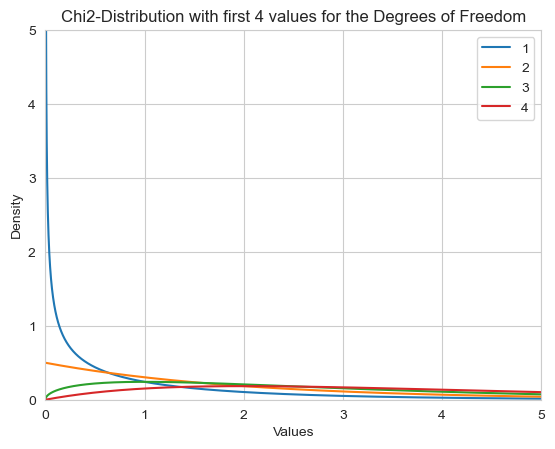

In [15]:
sns.set_style("whitegrid")

almacen = []
for degs in range(1,5):
    x_values = np.arange(0, 5, 0.001)
    y_values = chi2.pdf(x_values, df = degs)
    plt.plot(x_values,y_values)
    almacen.append(degs)
    print(degs)

plt.title('Chi2-Distribution with first 4 values for the Degrees of Freedom')
plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim(0,5)
plt.ylim(0,5)
plt.legend(almacen)

plt.show()

Remember also that as it is right-tailed as we can see in the above graphic. This is due to the quadratic character, it is, it does not have negative numbers.

In our shipments cases, we have a column that´s called *"vendor_inco_term"*.

- Definition: Incoterms are terms, of three letters each, that reflect the rules of voluntary acceptance by the parties to a contract for the international sale of goods regarding the terms of delivery of the goods.

The choices are:

- EXW: "Ex works". The buyer pays for transportation of the goods.
- CIP: "Carriage and insurance paid to". The seller pays for freight and insurance until the goods board a ship.
- DDP: "Delivered duty paid". The seller pays for transportation of the goods until they reach a destination port.
- FCA: "Free carrier". The seller pays for transportation of the goods.

And then, we ask ourselves, do they have any relation?

![](https://t4.ftcdn.net/jpg/04/22/66/55/360_F_422665506_tFNZlVlt5tu4tFLLnAdbbKkgaT8A2Qfm.jpg)

Sample of incoterms.


So, our null hypothesis and our alternative hypothesis are:

- $H_{0}$: The incoterm that is used and the freight cost groups are independent.
- $H_{A}$: The incoterm that is used and the freight cost groups are correlated.

And we pick an $\alpha$ 0f 0.1

-----------------------------

### Chi-2 Example

We can use **the pingouin package** to do directly the $\chi^{2}$ test, that needs the dataset, and the columns we are looking for a correlation, in our case, *freight_cost_groups* and *vendor_inco_term*.

There is an extra factor called *correlation* but it should only be used when the sample is small and there are not many degrees of freedom.

First, let´s explore the data with a barplot:

In [22]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)
props

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
DDU               reasonable             1.000000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: proportion, dtype: float64

As they are *normalize* they return a correlation between 0 and 1. Now, if we want to represent them in a graphic, we need them to be columns so **we use .unstack()** to transform them into *Wide Format*.

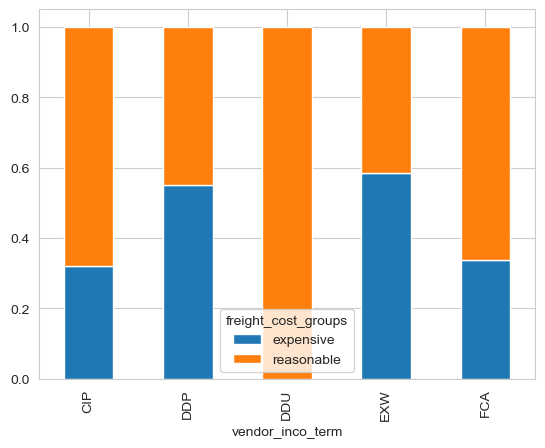

In [24]:
# Wideformat
wide_props = props.unstack()
wide_props.plot(kind="bar", stacked=True)
plt.show()

What do we conclude? At first sight, it is not indepndt the price we pay and the incoterm! Is **as easy as comparing if the bars are all at the same height**. That opens the possibility to do a $\chi^{2}$ test.

Using the structure provided above, **we do a $\chi^{2}$ test.**

In [27]:
# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = pingouin.chi2_independence(data = late_shipments,\
                                                       x = "freight_cost_groups", y = "vendor_inco_term")
stats[stats['test'] == 'pearson']

c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8073: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8073: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8070: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,34.805072,4.0,5.093922e-07,0.186561,0.999235


As we see in the columns *pval*, as $\mathit{p} <  \alpha$, we reject $H_{0}$ and we can say that they are correlated with a 90% of fidelity.

------------------------

## Chi-2 goodness of fit test

### The distribution comparator

This is another type of Chi-Square test but **rather than looking at the similarities between two variables what we see is that there is a distribution that is being followed by our variable**, such as a normal or a t-distribution.


Let´s have a look again to our incoterm column in the shipment dataset. If we count the values we have:

In [28]:
late_shipments["vendor_inco_term"].value_counts(),late_shipments["vendor_inco_term"].value_counts(normalize = True)

(vendor_inco_term
 EXW    732
 FCA    111
 DDP    100
 CIP     56
 DDU      1
 Name: count, dtype: int64,
 vendor_inco_term
 EXW    0.732
 FCA    0.111
 DDP    0.100
 CIP    0.056
 DDU    0.001
 Name: proportion, dtype: float64)

So we can say, that it approach more or less to this form:

- EXW: 0.75
- FCA: 0.1
- DDP: 0.1
- CIP: 0.05

But, is this statistically relevant or we cannot say that our incoterms follow this distribution? Let´s do the hypothesis tests.

- $H_{0}$: The sample matches with the hypothesized distribution.
- $H_{A}$: The sample does not match with the hypothesized distribution. 

**Notice that here the hypothesis test supports the distribution and we search to reject if they follow the same distro.**

Let´s have another look in a graphic. **We need to express our values as a DataFrame:**

In [30]:
data_hypo = {
    'vendor_inco_term' : ["EXW","FCA","DDP","CIP"],
    'prop' : [0.75,0.10,0.10,0.05]
}
inco_cnts= {
    'vendor_inco_term' : ["EXW","FCA","DDP","CIP"],
    'n' : [732,111,100,56]
}
hypothesized = pd.DataFrame(data_hypo)
incoterm_counts = pd.DataFrame(inco_cnts)

To compare the hypothesis with the actual values we need to know the quantity of values comparing the amount to the hypothesized proportions, that´s why we need the length and the n column to draw it:

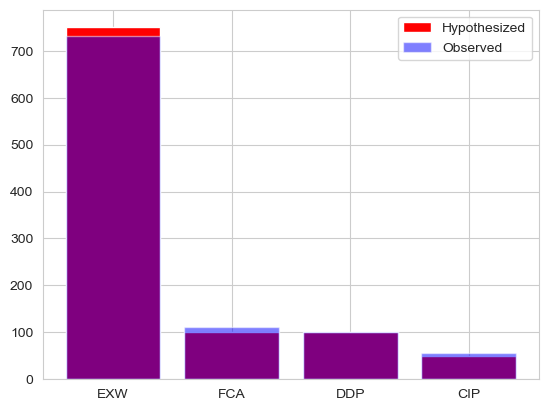

In [32]:
n_total = len(late_shipments)
hypothesized["n"] = hypothesized["prop"] * n_total #Hypothetic amount of the values

# Difference between the quantity of hypothetic incoterms vs actual incoterms
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], color="red", label="Hypothesized")
plt.bar(incoterm_counts['vendor_inco_term'], incoterm_counts['n'], color="blue", alpha = 0.5,label="Observed")
plt.legend()
plt.show()

They are very imilar so it has sense to do te $\chi^{2}$ goodness of fit test.

In [40]:
incoterm_counts['n'].sum(), hypothesized["n"].sum()

(0    732
 1    111
 2    100
 3     56
 Name: n, dtype: int64,
 0    750.0
 1    100.0
 2    100.0
 3     50.0
 Name: n, dtype: float64)

## A detail about the goodness of fit test

When the two samples have different lengths we need to make them equal to make this test work so in our case that we have 999 and 1000 elements, we need to take the smallest amount to do it.

In [61]:
rand_index = np.random.randint(0,3)

if incoterm_counts['n'].sum() <= 1000:
    incoterm_counts['n'][rand_index] = incoterm_counts['n'][rand_index] +1

incoterm_counts['n'].sum()

C:\Users\Manu\AppData\Local\Temp\ipykernel_17832\3428639921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incoterm_counts['n'][rand_index] = incoterm_counts['n'][rand_index] +1


1000

In [62]:
# Perform a goodness of fit test on the incoterm counts n
# import chisquare
chi2_test_stat, p_value = chisquare(f_obs = incoterm_counts['n'], f_exp = hypothesized['n'])

chi2_test_stat, p_value

(2.372, 0.49886809526262577)

So, we fail to reject the null hypothesis $H_{0}$ and they follow the same distribution as the hypothesized one.

------------------------------